<a href="https://colab.research.google.com/github/agi2019/ppi-gci/blob/main/tutorials/03%20-%20simple_prospective.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <center>Simple prospective simulation</center>

Prepared by Omar A. Guerrero (oguerrero@turing.ac.uk, <a href="https://twitter.com/guerrero_oa">@guerrero_oa</a>) Adapted for PPI-Global Cybersecurity Index (GCI) project on cybersecurity policy prioritisation

In this tutorial I will demonstrate how to perform simple prospective analysis by simulating the indicators forward 2 years and measuring the development gaps that would remain open. I will also show how to implement some intuitive visualisations.

## Importing Python libraries to manipulate and visualise data

In [155]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

Select Scenario

In [156]:
scenario = '_scenario1'
#scenario = '_scenario2'
#scenario = '_scenario3'

## Importing PPI functions

In [157]:
import requests
url = 'https://raw.githubusercontent.com/agi2019/ppi-gci/main/source_code/policy_priority_inference.py'
r = requests.get(url)
with open('policy_priority_inference.py', 'w') as f:
    f.write(r.text)
import policy_priority_inference as ppi

## Load data

Since I am now performing prospective simulations, the initial conditions are the most updated values, i.e. `IF`.

**New disbursement schedule for simulating next 2 years, assuming that expenditure will be the same as the last period of the sample**

In [158]:
# INDICATORS
df_indis = pd.read_csv('https://raw.githubusercontent.com/agi2019/ppi-gci/main/tutorials/clean_data'+scenario+'/data_indicators.csv')
N = len(df_indis) # number of indicators
I0 = df_indis.I0.values # initial values
R = df_indis.instrumental # instrumental indicators
qm = df_indis.qm.values # quality of monitoring
rl = df_indis.rl.values # quality of the rule of law
indis_index = dict([(code, i) for i, code in enumerate(df_indis.seriesCode)]) # used to build the network matrix
Imax = df_indis.maxVals.values
Imin = df_indis.minVals.values

# PARAMETERS
df_params = pd.read_csv('https://raw.githubusercontent.com/agi2019/ppi-gci/main/tutorials/clean_data'+scenario+'/parameters.csv')
alphas = df_params.alpha.values
alphas_prime = df_params.alpha_prime.values
betas = df_params.beta.values

# NETWORK
df_net = pd.read_csv('https://raw.githubusercontent.com/agi2019/ppi-gci/main/tutorials/clean_data'+scenario+'/data_network.csv')
A = np.zeros((N, N)) # adjacency matrix
for index, row in df_net.iterrows():
    i = indis_index[row.origin]
    j = indis_index[row.destination]
    w = row.weight
    A[i,j] = w

# DISBURSEMENT SCHEDULE (make sure that the disbursement schedule is consistent with T, otherwise PPI will simulate the T of the calibration)
T = 60 # recall that simulation steps are not equivalente to calendar time (see tutorial 01c - data preparation (expenditure))
df_exp = pd.read_csv('https://raw.githubusercontent.com/agi2019/ppi-gci/main/tutorials/clean_data'+scenario+'/data_expenditure.csv')
Bs_retrospective = df_exp.values[:,1::] # disbursement schedule (assumes that the expenditure programmes are properly sorted)
# Create a new disbursement schedule assuming that expenditure will be the same as the last period of the sample
Bs = np.tile(Bs_retrospective[:,-1], (T,1)).T

# RELATIONAL TABLE
df_rela = pd.read_csv('https://raw.githubusercontent.com/agi2019/ppi-gci/main/tutorials/clean_data'+scenario+'/data_relational_table.csv')
B_dict = {}
for index, row in df_rela.iterrows():
    B_dict[indis_index[row.seriesCode]] = [programme for programme in row.values[1::][row.values[1::].astype(str)!='nan']]

In [159]:
df_indis

,2020,2021,2022,2023,2024,seriesCode,sdg,minVals,maxVals,instrumental,seriesName,color,I0,IF,successRates,qm,rl
0,0.878521,0.917535,0.952349,0.980618,1.0,gci11_Lonline,11,0.0,1.0,1,Laws on unauthorized online behavior,#A21942,0.878521,1.00,0.8,0.467,0.3632
1,0.771576,0.778983,0.810364,0.879456,1.0,gci11_Lforgery,11,0.0,1.0,1,legislation in force related to computer-relat...,#A21942,0.771576,1.00,0.8,0.467,0.3632
2,0.682146,0.697800,0.750377,0.848302,1.0,gci11_Lolsafety,11,0.0,1.0,1,Laws on online safety,#A21942,0.682146,1.00,0.8,0.467,0.3632
3,0.896473,0.939432,0.972043,0.992751,1.0,gci12_Rpdp,12,0.0,1.0,1,Regulation(s) related to personal data protect...,#FF3A21,0.896473,1.00,0.8,0.467,0.3632
4,1.000000,1.000000,1.000000,1.000000,1.0,gci12_Rprivacy,12,0.0,1.0,1,Regulation(s) related to privacy protection,#FF3A21,1.000000,1.05,0.0,0.467,0.3632
5,1.000000,1.000000,1.000000,1.000000,1.0,gci12_Rnotif,12,0.0,1.0,1,Regulation(s) related to data breach/incident ...,#FF3A21,1.000000,1.05,0.0,0.467,0.3632
6,1.000000,1.000000,1.000000,1.000000,1.0,gci12_RAuditre,12,0.0,1.0,1,Regulation(s) related to cybersecurity audit r...,#FF3A21,1.000000,1.05,0.0,0.467,0.3632
7,0.923469,0.924664,0.933035,0.955755,1.0,gci12_Rstandard,12,0.0,1.0,1,Regulation(s) related to cybersecurity standar...,#FF3A21,0.923469,1.00,0.8,0.467,0.3632
8,0.790382,0.799043,0.830946,0.894971,1.0,gci12_Rsign,12,0.0,1.0,1,Regulation(s) related to use of digital signat...,#FF3A21,0.790382,1.00,0.8,0.467,0.3632
9,0.886504,0.888278,0.900691,0.934385,1.0,gci12_Rspam,12,0.0,1.0,1,Regulation(s) related to unsolicited communica...,#FF3A21,0.886504,1.00,0.8,0.467,0.3632


In [160]:
df_exp

,sdg,0,1,2,3,4,5,6,7,8,...,50,51,52,53,54,55,56,57,58,59
0,11.0,3.468270e+08,3.468270e+08,3.468270e+08,3.468270e+08,3.468270e+08,3.468270e+08,3.468270e+08,3.468270e+08,3.468270e+08,...,7.104250e+08,7.104250e+08,7.104250e+08,7.104250e+08,7.104250e+08,7.104250e+08,7.104250e+08,7.104250e+08,7.104250e+08,7.104250e+08
1,12.0,1.801732e+09,1.801732e+09,1.801732e+09,1.801732e+09,1.801732e+09,1.801732e+09,1.801732e+09,1.801732e+09,1.801732e+09,...,1.465454e+09,1.465454e+09,1.465454e+09,1.465454e+09,1.465454e+09,1.465454e+09,1.465454e+09,1.465454e+09,1.465454e+09,1.465454e+09
2,21.0,2.020000e+11,2.020000e+11,2.020000e+11,2.020000e+11,2.020000e+11,2.020000e+11,2.020000e+11,2.020000e+11,2.020000e+11,...,9.116751e+09,9.116751e+09,9.116751e+09,9.116751e+09,9.116751e+09,9.116751e+09,9.116751e+09,9.116751e+09,9.116751e+09,9.116751e+09
3,22.0,1.639301e+09,1.639301e+09,1.639301e+09,1.639301e+09,1.639301e+09,1.639301e+09,1.639301e+09,1.639301e+09,1.639301e+09,...,3.895992e+09,3.895992e+09,3.895992e+09,3.895992e+09,3.895992e+09,3.895992e+09,3.895992e+09,3.895992e+09,3.895992e+09,3.895992e+09
4,23.0,1.102958e+09,1.102958e+09,1.102958e+09,1.102958e+09,1.102958e+09,1.102958e+09,1.102958e+09,1.102958e+09,1.102958e+09,...,8.250830e+08,8.250830e+08,8.250830e+08,8.250830e+08,8.250830e+08,8.250830e+08,8.250830e+08,8.250830e+08,8.250830e+08,8.250830e+08
5,31.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,5.827820e+08,5.827820e+08,5.827820e+08,5.827820e+08,5.827820e+08,5.827820e+08,5.827820e+08,5.827820e+08,5.827820e+08,5.827820e+08
6,32.0,2.227224e+10,2.227224e+10,2.227224e+10,2.227224e+10,2.227224e+10,2.227224e+10,2.227224e+10,2.227224e+10,2.227224e+10,...,2.030000e+11,2.030000e+11,2.030000e+11,2.030000e+11,2.030000e+11,2.030000e+11,2.030000e+11,2.030000e+11,2.030000e+11,2.030000e+11
7,33.0,3.415830e+09,3.415830e+09,3.415830e+09,3.415830e+09,3.415830e+09,3.415830e+09,3.415830e+09,3.415830e+09,3.415830e+09,...,2.295202e+09,2.295202e+09,2.295202e+09,2.295202e+09,2.295202e+09,2.295202e+09,2.295202e+09,2.295202e+09,2.295202e+09,2.295202e+09
8,41.0,3.186560e+09,3.186560e+09,3.186560e+09,3.186560e+09,3.186560e+09,3.186560e+09,3.186560e+09,3.186560e+09,3.186560e+09,...,1.427205e+09,1.427205e+09,1.427205e+09,1.427205e+09,1.427205e+09,1.427205e+09,1.427205e+09,1.427205e+09,1.427205e+09,1.427205e+09
9,42.0,1.471262e+10,1.471262e+10,1.471262e+10,1.471262e+10,1.471262e+10,1.471262e+10,1.471262e+10,1.471262e+10,1.471262e+10,...,4.250964e+09,4.250964e+09,4.250964e+09,4.250964e+09,4.250964e+09,4.250964e+09,4.250964e+09,4.250964e+09,4.250964e+09,4.250964e+09


In [161]:
Bs_retrospective

array([[3.4682700e+08, 3.4682700e+08, 3.4682700e+08, ..., 7.1042500e+08,
        7.1042500e+08, 7.1042500e+08],
       [1.8017315e+09, 1.8017315e+09, 1.8017315e+09, ..., 1.4654535e+09,
        1.4654535e+09, 1.4654535e+09],
       [2.0200000e+11, 2.0200000e+11, 2.0200000e+11, ..., 9.1167510e+09,
        9.1167510e+09, 9.1167510e+09],
       ...,
       [5.2258000e+07, 5.2258000e+07, 5.2258000e+07, ..., 1.6951950e+08,
        1.6951950e+08, 1.6951950e+08],
       [8.3861950e+08, 8.3861950e+08, 8.3861950e+08, ..., 2.8390750e+08,
        2.8390750e+08, 2.8390750e+08],
       [3.0717900e+08, 3.0717900e+08, 3.0717900e+08, ..., 2.1217350e+08,
        2.1217350e+08, 2.1217350e+08]])

In [162]:
Bs

array([[7.1042500e+08, 7.1042500e+08, 7.1042500e+08, ..., 7.1042500e+08,
        7.1042500e+08, 7.1042500e+08],
       [1.4654535e+09, 1.4654535e+09, 1.4654535e+09, ..., 1.4654535e+09,
        1.4654535e+09, 1.4654535e+09],
       [9.1167510e+09, 9.1167510e+09, 9.1167510e+09, ..., 9.1167510e+09,
        9.1167510e+09, 9.1167510e+09],
       ...,
       [1.6951950e+08, 1.6951950e+08, 1.6951950e+08, ..., 1.6951950e+08,
        1.6951950e+08, 1.6951950e+08],
       [2.8390750e+08, 2.8390750e+08, 2.8390750e+08, ..., 2.8390750e+08,
        2.8390750e+08, 2.8390750e+08],
       [2.1217350e+08, 2.1217350e+08, 2.1217350e+08, ..., 2.1217350e+08,
        2.1217350e+08, 2.1217350e+08]])

## Development goals

To measure development gaps, it is important to reflect the direction of improvement envisioned by the government. In this study, I adopt a simplified approach by setting the goal for each GCI indicator at its maximum value (100/100). This is not to suggest that all indicators are expected to reach this level in practice, but rather to provide a consistent reference point for identifying potential gaps. The decision is informed by the fact that Indonesia has already achieved the full score in certain indicators in the 2024 GCI assessment. Using the maximum value as a goal helps to highlight areas that may still require attention, while keeping the model straightforward at this stage of analysis..

In [163]:
# goals = np.random.rand(N)*(Imax - I0) + I0
goals = Imax

## Simulate

PPI has inherent stochasticity, so a single model run may not be representative of the average output behaviour. I obviated this in the calibration tutorial as much of the simulation sampling is hidden behind the functions. Here, I would like to be more explicit regarding the Monte Carlo sampling procedure, and how to construct the average time series (across simulations) of the indicators. I will use this information to estimate the development gaps that will remain in 2 years.

In [164]:
sample_size = 100 # number of Monte Carlo simulations

outputs = []
for sample in range(sample_size):
    output = ppi.run_ppi(I0, alphas, alphas_prime, betas, A=A, R=R, qm=qm, rl=rl,
                Imax=Imax, Imin=Imin, Bs=Bs, B_dict=B_dict, T=T, G=goals)
    outputs.append(output)

In [165]:
# separate the outputs into lists of time series
tsI, tsC, tsF, tsP, tsS, tsG = zip(*outputs)

# compute the average time series of the indicators
tsI_hat = np.mean(tsI, axis=0)

# make a new DataFrame with the indicators' information
new_rows = []
for i, serie in enumerate(tsI_hat):
    new_row = [df_indis.iloc[i].seriesCode, df_indis.iloc[i].sdg, df_indis.iloc[i].color] + serie.tolist()
    new_rows.append(new_row)

df_output = pd.DataFrame(new_rows, columns=['seriesCode', 'sdg', 'color']+list(range(T)))
df_output['goal'] = goals

In [166]:
df_output

,seriesCode,sdg,color,0,1,2,3,4,5,6,...,51,52,53,54,55,56,57,58,59,goal
0,gci11_Lonline,11,#A21942,0.878521,0.882633,0.886096,0.889559,0.893022,0.896485,0.898858,...,0.999085,0.999435,0.999651,0.999867,1.000000,1.000000,1.000000,1.000000,1.000000,1.0
1,gci11_Lforgery,11,#A21942,0.771576,0.778366,0.784665,0.790309,0.796200,0.801926,0.808062,...,0.993859,0.994350,0.994753,0.995231,0.995558,0.995640,0.995967,0.996527,0.996772,1.0
2,gci11_Lolsafety,11,#A21942,0.682146,0.692512,0.702416,0.711630,0.720959,0.730402,0.739962,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0
3,gci12_Rpdp,12,#FF3A21,0.896473,0.902608,0.905676,0.908563,0.911630,0.914517,0.916694,...,0.999326,0.999506,0.999687,0.999867,1.000000,1.000000,1.000000,1.000000,1.000000,1.0
4,gci12_Rprivacy,12,#FF3A21,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0
5,gci12_Rnotif,12,#FF3A21,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0
6,gci12_RAuditre,12,#FF3A21,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0
7,gci12_Rstandard,12,#FF3A21,0.923469,0.924895,0.926343,0.927923,0.929415,0.930841,0.932355,...,0.991592,0.992220,0.992782,0.993126,0.993600,0.993878,0.994273,0.994616,0.994962,1.0
8,gci12_Rsign,12,#FF3A21,0.790382,0.796175,0.801551,0.806687,0.811764,0.816840,0.821858,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0
9,gci12_Rspam,12,#FF3A21,0.886504,0.889404,0.892172,0.894808,0.897477,0.900015,0.902585,...,0.996885,0.997079,0.997441,0.997654,0.997848,0.998009,0.998221,0.998452,0.998551,1.0


## Visualise

First, we visualise the evolution of the indicators.

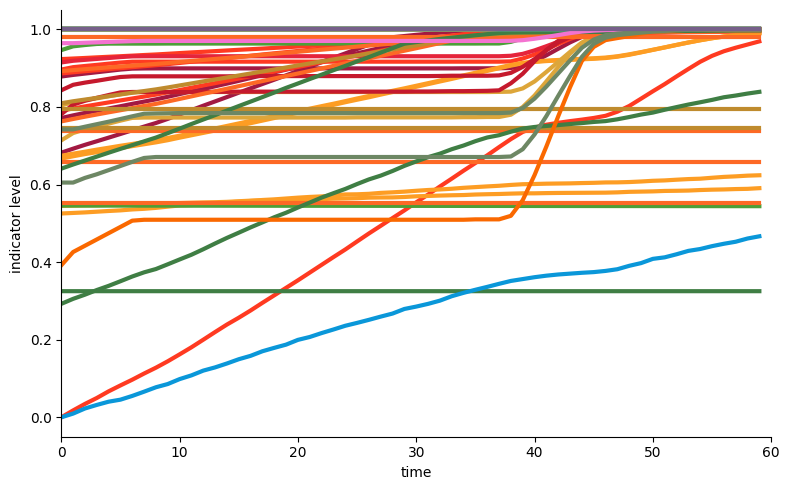

In [167]:
plt.figure(figsize=(8, 5))
for index, row in df_output.iterrows():
    plt.plot(row[range(T)], color=row.color, linewidth=3)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.xlim(0,T)
plt.xlabel('time')
plt.ylabel('indicator level')
plt.tight_layout()

Next, we visualise the evolution of the indicators in terms of their change with regards to the initial conditions. Notice how some indicators improve while others worsen. This is useful information to prioritise budgetary interventions.

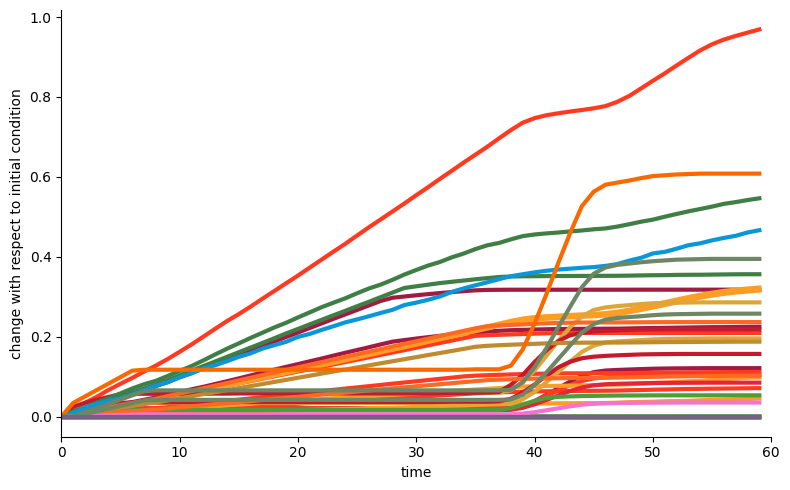

In [168]:
plt.figure(figsize=(8, 5))
for index, row in df_output.iterrows():
    plt.plot(row[range(T)]-row[0], color=row.color, linewidth=3)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.xlim(0,T)
plt.xlabel('time')
plt.ylabel('change with respect to initial condition')
plt.tight_layout()

Now, let's display the final values of the indicators and the goals that the government is trying to achieve. The distance between the bars and the dots (the thin line) denote the development gaps that would remain open in 10 years.

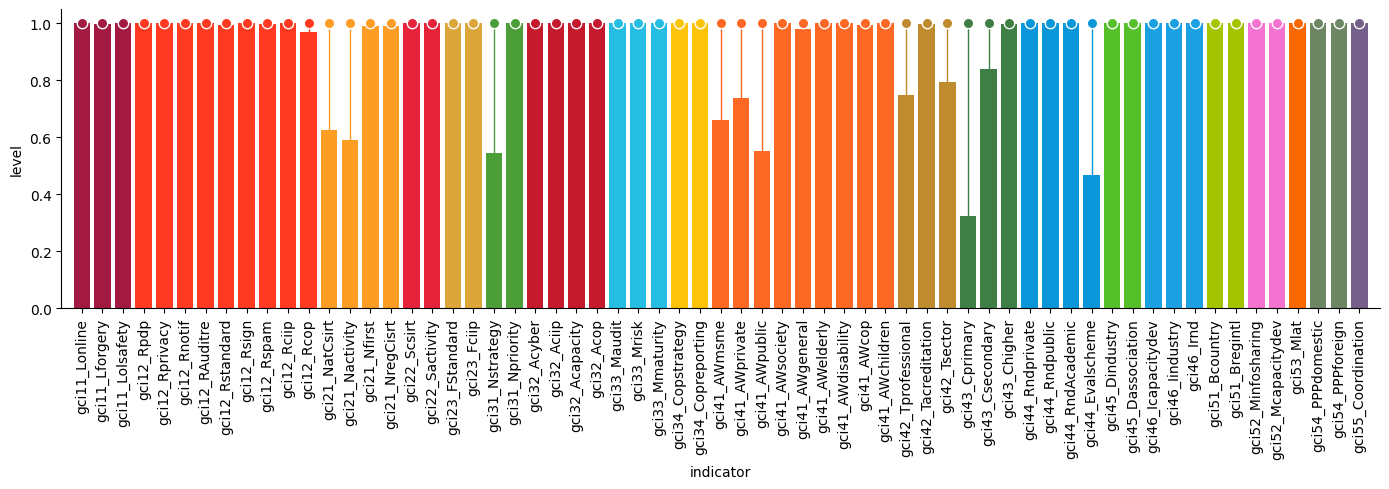

In [169]:
plt.figure(figsize=(14, 5))
for index, row in df_output.iterrows():
    plt.bar(index, row[T-1], color=row.color, linewidth=3)
    plt.plot([index, index], [row[T-1], row.goal], color=row.color, linewidth=1)
    plt.plot(index, row.goal, '.', mec='w', mfc=row.color, markersize=15)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.xlim(-1, N)
plt.xticks(range(N))
plt.gca().set_xticklabels(df_output.seriesCode, rotation=90)
plt.xlabel('indicator')
plt.ylabel('level')
plt.tight_layout()

## Simulated intervention

Finally, let me show an example of a simulated intervention through a gradual increase of government expenditure. Let me assume that the government decides to implement linear increments such that, in 2 years, the amount of expenditure triplicates. Here, I show how to implement this intervention through the disbursement schedule and, then how to analyse the difference in development gaps between the baseline prospective and this counterfactual.

In [170]:
# define linear growth coefficients
linear_growth = np.tile(np.linspace(0, 2, T), (Bs.shape[0],1))
Bs3 = Bs*(1+linear_growth)

outputs = []
for sample in range(sample_size):
    output = ppi.run_ppi(I0, alphas, alphas_prime, betas, A=A, R=R, qm=qm, rl=rl,
                Imax=Imax, Imin=Imin, Bs=Bs3, B_dict=B_dict, T=T, G=goals)
    outputs.append(output)

# separate the outputs into lists of time series
tsI, tsC, tsF, tsP, tsS, tsG = zip(*outputs)

# copmute the average time series of the indicators
tsI_hat = np.mean(tsI, axis=0)

# make a new dataframe with the indicators' information
new_rows = []
for i, serie in enumerate(tsI_hat):
    new_row = [df_indis.iloc[i].seriesCode, df_indis.iloc[i].sdg, df_indis.iloc[i].color] + serie.tolist()
    new_rows.append(new_row)

df_output2 = pd.DataFrame(new_rows, columns=['seriesCode', 'sdg', 'color']+list(range(T)))
df_output2['goal'] = goals

Now we compute the development gaps of the baseline and the counterfactual, and present them in a scatter plot to show which indicators respond to the intervention. If a dot lies below the 45-degree line, it means that the gap reduced due to the budget increment. In this example, we can see that some indicators respond, but the gap reductions are quite modest. In the next tutorial I will show how to use this information in search of structural bottlenecks.

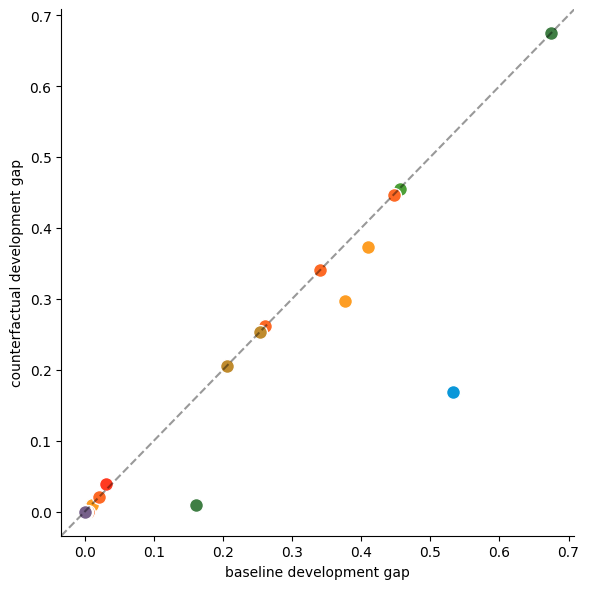

In [171]:
plt.figure(figsize=(6, 6))
for index, row in df_output.iterrows():
    if row.goal > row[T-1]:  # consider only those indicators that would not reach their goals
        plt.plot((row.goal-row[T-1]), (df_output2.iloc[index].goal-df_output2.iloc[index][T-1]),
                 '.', mec='w', mfc=row.color, markersize=20)
# garis x = y transparan
lims = [
    min(plt.xlim()[0], plt.ylim()[0]),  # ambil batas bawah terendah
    max(plt.xlim()[1], plt.ylim()[1])   # ambil batas atas tertinggi
]
plt.plot(lims, lims, linestyle='--', linewidth=1.5, alpha=0.4, color='k')
plt.xlim(lims)
plt.ylim(lims)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.xlabel('baseline development gap')
plt.ylabel('counterfactual development gap')
plt.tight_layout()

## Visualization of Post-Intervention Outcomes
I developed a visual representation of the projected indicator trajectories following the initial budget intervention. This visualization provides a clearer understanding of how the simulated increase in budget influences the closing of development gaps over time. It also serves as a tool to compare the evolution of indicators under the baseline (non-intervention) scenario and the counterfactual intervention scenario, highlighting areas where policy adjustments may be yielding the most significant returns.

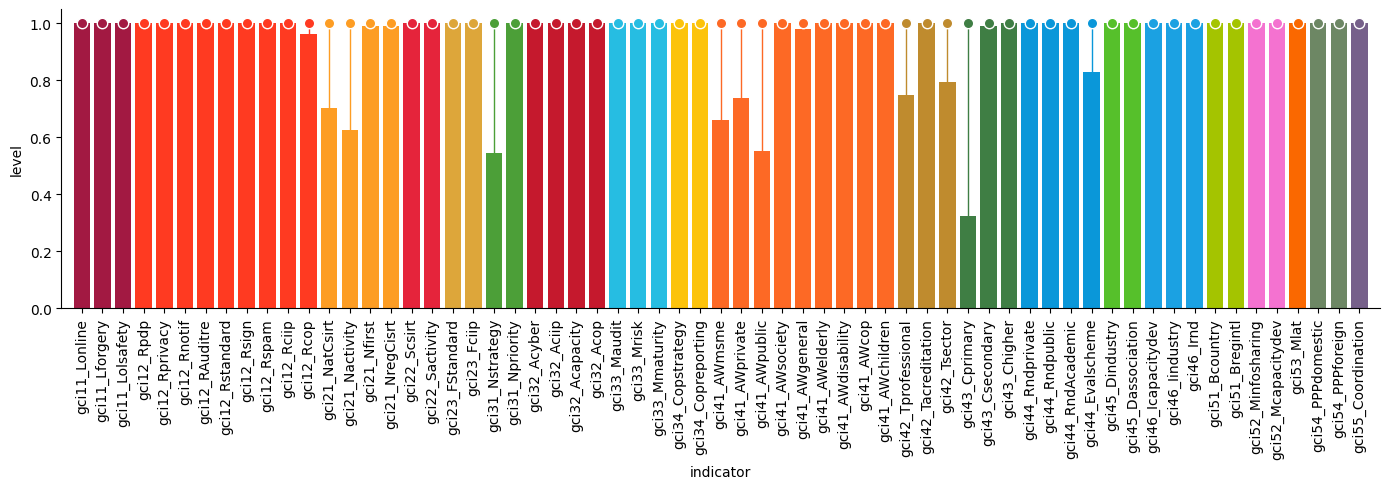

In [172]:
plt.figure(figsize=(14, 5))
for index, row in df_output2.iterrows():
    plt.bar(index, row[T-1], color=row.color, linewidth=3)
    plt.plot([index, index], [row[T-1], row.goal], color=row.color, linewidth=1)
    plt.plot(index, row.goal, '.', mec='w', mfc=row.color, markersize=15)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.xlim(-1, N)
plt.xticks(range(N))
plt.gca().set_xticklabels(df_output2.seriesCode, rotation=90)
plt.xlabel('indicator')
plt.ylabel('level')
plt.tight_layout()

In [173]:
# prompt: give the output containing table with the collumn of Indicators and the value of row[T-1]

print(df_output[['seriesCode', T-1]])

             seriesCode        59
0         gci11_Lonline  1.000000
1        gci11_Lforgery  0.996772
2       gci11_Lolsafety  1.000000
3            gci12_Rpdp  1.000000
4        gci12_Rprivacy  1.000000
5          gci12_Rnotif  1.000000
6        gci12_RAuditre  1.000000
7       gci12_Rstandard  0.994962
8           gci12_Rsign  1.000000
9           gci12_Rspam  0.998551
10          gci12_Rciip  1.000000
11           gci12_Rcop  0.969120
12       gci21_NatCsirt  0.623997
13      gci21_Nactivity  0.590719
14         gci21_Nfirst  0.990159
15      gci21_NregCisrt  0.989890
16         gci22_Scsirt  1.000000
17      gci22_Sactivity  1.000000
18      gci23_FStandard  1.000000
19          gci23_Fciip  1.000000
20      gci31_Nstrategy  0.544300
21      gci31_Npriority  1.000000
22         gci32_Acyber  1.000000
23          gci32_Aciip  1.000000
24      gci32_Acapacity  1.000000
25           gci32_Acop  0.999998
26         gci33_Maudit  1.000000
27          gci33_Mrisk  1.000000
28      gci33_

In addition to the baseline intervention scenario—where a gradual linear increase in government expenditure results in a threefold rise over a four-year period—I conducted a series of additional intervention simulations to explore the model's responsiveness under different budget reallocation strategies. These interventions are designed to assess the potential outcomes of more targeted or corrective policy actions, especially in the context of uneven indicator performance as observed in Indonesia's GCI data.

## Targeted Intervention on Low-Performing Indicators
Second, I simulated a scenario in which a fourfold increase in expenditure is applied selectively to indicators that currently exhibit low baseline performance. The rationale behind this targeted approach is to explore whether concentrating resources on lagging areas can accelerate progress more effectively than uniform budget increases. This simulation helps identify whether such targeted allocations produce disproportionately positive effects on specific indicators, which may have structural or institutional bottlenecks that require greater policy attention.

In [174]:
# define linear growth coefficients
#linear_growth = np.tile(np.linspace(0, 2, T), (Bs.shape[0], 1))
BsSelected = Bs.copy()
rows_to_increase = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17]
#BsSelected[rows_to_increase, :] *= (1 + linear_growth[rows_to_increase, :])
BsSelected[rows_to_increase, :] *= 4

outputs = []
for sample in range(sample_size):
    output = ppi.run_ppi(I0, alphas, alphas_prime, betas, A=A, R=R, qm=qm, rl=rl,
                Imax=Imax, Imin=Imin, Bs=BsSelected, B_dict=B_dict, T=T, G=goals)
    outputs.append(output)

# separate the outputs into lists of time series
tsI, tsC, tsF, tsP, tsS, tsG = zip(*outputs)

# copmute the average time series of the indicators
tsI_hat = np.mean(tsI, axis=0)

# make a new dataframe with the indicators' information
new_rows = []
for i, serie in enumerate(tsI_hat):
    new_row = [df_indis.iloc[i].seriesCode, df_indis.iloc[i].sdg, df_indis.iloc[i].color] + serie.tolist()
    new_rows.append(new_row)

df_output3 = pd.DataFrame(new_rows, columns=['seriesCode', 'sdg', 'color']+list(range(T)))
df_output3['goal'] = goals

## Reallocation from High-Performing Indicators
I explored the inverse of the previous approach by simulating a scenario where budget allocations are reduced by a factor of four for indicators that already demonstrate high performance. The aim of this scenario is to test the sensitivity of well-performing areas to budget contractions and to evaluate the trade-offs involved in reallocating resources away from strong areas toward weaker ones. This allows for the examination of possible unintended consequences and the robustness of high-performing indicators when subject to reduced investment.

In [175]:
BsSelected2 = Bs/4
#BsSelected2 = Bs.copy()
#rows_to_increase = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16]  # baris yang akan dinaikkan bertahap
#BsSelected[rows_to_increase, :] *= (1 + linear_growth[rows_to_increase, :])
#BsSelected2[rows_to_increase, :] /= 10
#BsSelected2 = np.tile(Bs_retrospective[:,-49], (T,1)).T
outputs = []
for sample in range(sample_size):
    output = ppi.run_ppi(I0, alphas, alphas_prime, betas, A=A, R=R, qm=qm, rl=rl,
                Imax=Imax, Imin=Imin, Bs=BsSelected2, B_dict=B_dict, T=T, G=goals)
    outputs.append(output)

# separate the outputs into lists of time series
tsI, tsC, tsF, tsP, tsS, tsG = zip(*outputs)

# copmute the average time series of the indicators
tsI_hat = np.mean(tsI, axis=0)

# make a new dataframe with the indicators' information
new_rows = []
for i, serie in enumerate(tsI_hat):
    new_row = [df_indis.iloc[i].seriesCode, df_indis.iloc[i].sdg, df_indis.iloc[i].color] + serie.tolist()
    new_rows.append(new_row)

df_output4 = pd.DataFrame(new_rows, columns=['seriesCode', 'sdg', 'color']+list(range(T)))
df_output4['goal'] = goals

In [176]:
Bs

array([[7.1042500e+08, 7.1042500e+08, 7.1042500e+08, ..., 7.1042500e+08,
        7.1042500e+08, 7.1042500e+08],
       [1.4654535e+09, 1.4654535e+09, 1.4654535e+09, ..., 1.4654535e+09,
        1.4654535e+09, 1.4654535e+09],
       [9.1167510e+09, 9.1167510e+09, 9.1167510e+09, ..., 9.1167510e+09,
        9.1167510e+09, 9.1167510e+09],
       ...,
       [1.6951950e+08, 1.6951950e+08, 1.6951950e+08, ..., 1.6951950e+08,
        1.6951950e+08, 1.6951950e+08],
       [2.8390750e+08, 2.8390750e+08, 2.8390750e+08, ..., 2.8390750e+08,
        2.8390750e+08, 2.8390750e+08],
       [2.1217350e+08, 2.1217350e+08, 2.1217350e+08, ..., 2.1217350e+08,
        2.1217350e+08, 2.1217350e+08]])

In [177]:
BsSelected

array([[2.8417000e+09, 2.8417000e+09, 2.8417000e+09, ..., 2.8417000e+09,
        2.8417000e+09, 2.8417000e+09],
       [5.8618140e+09, 5.8618140e+09, 5.8618140e+09, ..., 5.8618140e+09,
        5.8618140e+09, 5.8618140e+09],
       [3.6467004e+10, 3.6467004e+10, 3.6467004e+10, ..., 3.6467004e+10,
        3.6467004e+10, 3.6467004e+10],
       ...,
       [6.7807800e+08, 6.7807800e+08, 6.7807800e+08, ..., 6.7807800e+08,
        6.7807800e+08, 6.7807800e+08],
       [1.1356300e+09, 1.1356300e+09, 1.1356300e+09, ..., 1.1356300e+09,
        1.1356300e+09, 1.1356300e+09],
       [8.4869400e+08, 8.4869400e+08, 8.4869400e+08, ..., 8.4869400e+08,
        8.4869400e+08, 8.4869400e+08]])

In [178]:
BsSelected2

array([[1.77606250e+08, 1.77606250e+08, 1.77606250e+08, ...,
        1.77606250e+08, 1.77606250e+08, 1.77606250e+08],
       [3.66363375e+08, 3.66363375e+08, 3.66363375e+08, ...,
        3.66363375e+08, 3.66363375e+08, 3.66363375e+08],
       [2.27918775e+09, 2.27918775e+09, 2.27918775e+09, ...,
        2.27918775e+09, 2.27918775e+09, 2.27918775e+09],
       ...,
       [4.23798750e+07, 4.23798750e+07, 4.23798750e+07, ...,
        4.23798750e+07, 4.23798750e+07, 4.23798750e+07],
       [7.09768750e+07, 7.09768750e+07, 7.09768750e+07, ...,
        7.09768750e+07, 7.09768750e+07, 7.09768750e+07],
       [5.30433750e+07, 5.30433750e+07, 5.30433750e+07, ...,
        5.30433750e+07, 5.30433750e+07, 5.30433750e+07]])

In [182]:
pd.set_option('display.max_rows', None)
combined = pd.DataFrame({
    "indicators": df_output['seriesCode'],
    "ratio /": df_output4[T-1]/df_output[T-1]*100,
    "quarter": df_output4[T-1],
    "original budget": df_output[T-1],
    "four times": df_output3[T-1],
    "ratio *": df_output3[T-1]/df_output[T-1]*100,
})


# Print the combined table
combined

,indicators,ratio /,quarter,original budget,four times,ratio *
0,gci11_Lonline,99.711021,0.997110,1.000000,1.000000,100.000000
1,gci11_Lforgery,85.516159,0.852401,0.996772,1.000000,100.323819
2,gci11_Lolsafety,83.274186,0.832742,1.000000,1.000000,100.000000
3,gci12_Rpdp,100.000000,1.000000,1.000000,1.000000,100.000000
4,gci12_Rprivacy,100.000000,1.000000,1.000000,1.000000,100.000000
5,gci12_Rnotif,100.000000,1.000000,1.000000,1.000000,100.000000
6,gci12_RAuditre,100.000000,1.000000,1.000000,1.000000,100.000000
7,gci12_Rstandard,94.849965,0.943721,0.994962,1.000000,100.506395
8,gci12_Rsign,91.317925,0.913179,1.000000,1.000000,100.000000
9,gci12_Rspam,93.062459,0.929276,0.998551,1.000000,100.145157


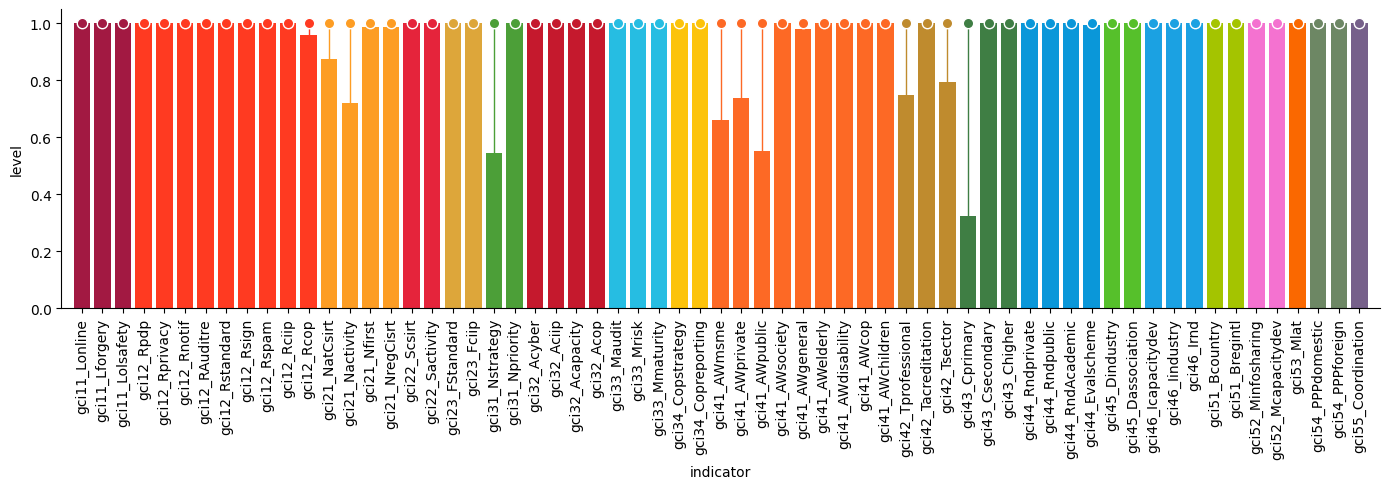

In [180]:
## visualization of *4
plt.figure(figsize=(14, 5))
for index, row in df_output3.iterrows():
    plt.bar(index, row[T-1], color=row.color, linewidth=3)
    plt.plot([index, index], [row[T-1], row.goal], color=row.color, linewidth=1)
    plt.plot(index, row.goal, '.', mec='w', mfc=row.color, markersize=15)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.xlim(-1, N)
plt.xticks(range(N))
plt.gca().set_xticklabels(df_output3.seriesCode, rotation=90)
plt.xlabel('indicator')
plt.ylabel('level')
plt.tight_layout()

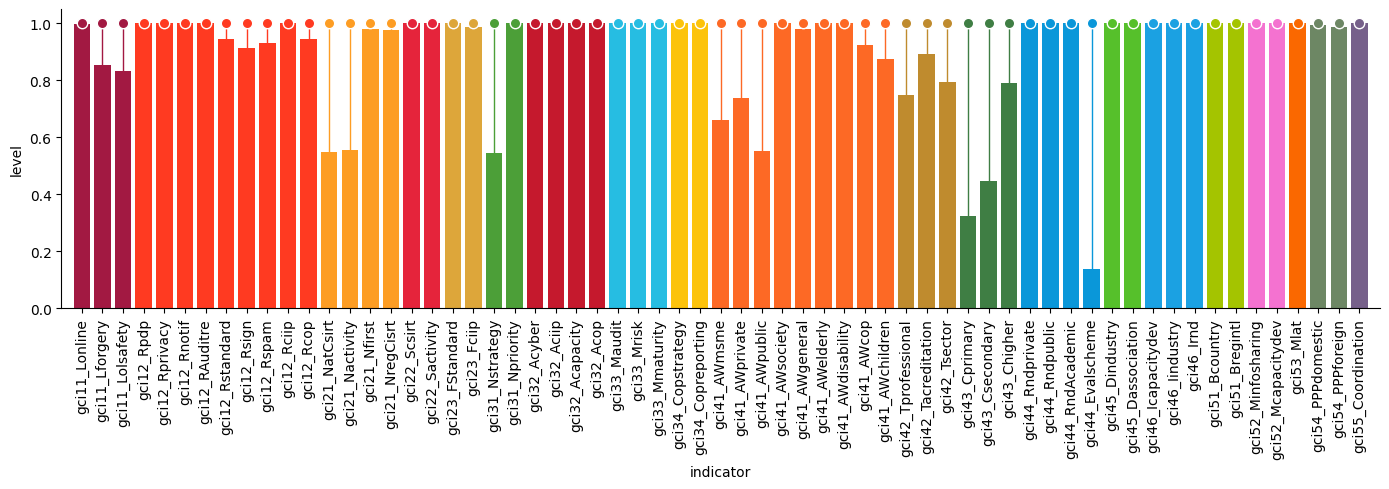

In [181]:
## visualization of /4
plt.figure(figsize=(14, 5))
for index, row in df_output4.iterrows():
    plt.bar(index, row[T-1], color=row.color, linewidth=3)
    plt.plot([index, index], [row[T-1], row.goal], color=row.color, linewidth=1)
    plt.plot(index, row.goal, '.', mec='w', mfc=row.color, markersize=15)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.xlim(-1, N)
plt.xticks(range(N))
plt.gca().set_xticklabels(df_output4.seriesCode, rotation=90)
plt.xlabel('indicator')
plt.ylabel('level')
plt.tight_layout()